# Generative adversarial network (GAN) for novelty detection

This notebook shows how to use the GAN method for novelty detection for the Mastcam multispectral image dataset. We modified the bidirectional GAN (BiGAN) implementation from Zenati et al. (2018) to use our Mastcam dataset. The original implementation by Zenati et al. can be found here: https://github.com/houssamzenati/Efficient-GAN-Anomaly-Detection 

Zenati et al. (2018). Adversarially learned anomaly detection. *Proceedings of the 20th IEEE International Conference on Data Mining (ICDM).* https://arxiv.org/abs/1812.02288

## 1. Train the BiGAN using typical images

To train the BiGAN using the training dataset of typical Mastcam images, navigate to the `gan` directory and run the following command:

`python main.py bigan mcam run --nb_epochs=100 --rd=42 --w=0.1 --label demo`

This will create a log directory at the following path:

`./bigan_results/train_logs/mcam/fm/0.1/demo/42`

The trained model checkpoint will be saved at:

`./bigan_results/train_logs/mcam/fm/0.1/demo/42/model.ckpt`

## 2. Compute novelty scores for test images

Using the trained BiGAN, we run the (novel and typical) test images through the discriminator and generator and compute a novelty score that is the weighted sum of the discriminator and generator loss. This can be done by running the following command:

`python main.py bigan mcam run --nb_epochs=100 --rd=42 --w=0.1`

The novelty scores for the test dataset will be saved at:

`./results/bigan/mcam/fm/0.1/demo-all_results.txt`

This file contains the novelty scores, predicted class, true class, and filenames of the test images (which includes both novel and typical test images). Note that `test_mcam.py` by default uses the full test dataset with all images from the novel dataset. To only use the novel images from one of the subcategories of novel images, you will need to replace line 47 in `test_mcam.py` to one of the following: `'bedrock', 'brokenrock', 'drillhole', 'drt', 'dumppile', 'float', 'meteorite', 'veins'`.

from `test_mcam.py`: <br>
`testx, testy, testnames = data.get_test('all')`

## 3. Evaluate BiGAN performance for novelty detection
We used two metrics for quantitatively evaluating performance: area under the curve (AUC) of the receiver operator characteristic (ROC) curve and precision at N. Precision at N is the fraction of correct classifications in the top N images when sorted by novelty score (i.e., the fraction of novel images in the top N test images sorted by novelty score).

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os

Load the results file from the BiGAN. This includes both novel and typical test data.

In [31]:
# Load the results file with scores and filenames 
results_fn = './results/bigan/mcam/fm/0.1/demo-%s_results.txt'

In [32]:
novel_categories = ['all', 'bedrock', 'brokenrock', 'drillhole', 'drt', 'dumppile', 'float', 'meteorite', 'veins']

In [38]:
scores = {}
for cat in novel_categories:
    df = pd.read_table(results_fn % cat, delimiter=' ', names=['score', 'pred', 'label', 'name'])
    scores[cat] = df

Plot the distribution of novelty scores for each class. For the GAN, a label of -1 means novel and a label of 1 means typical. 

Text(0,0.5,'Density')

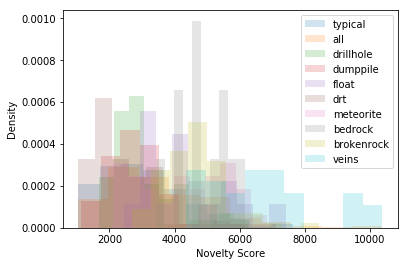

In [54]:
plt.hist(scores['all'][scores['all']['label'] == 0]['score'], alpha=0.2, label='typical', density=True)
for cat in scores.keys():
    plt.hist(scores[cat][scores[cat]['label'] == 1]['score'], alpha=0.2, label=cat, density=True)
plt.legend()
plt.xlabel('Novelty Score')
plt.ylabel('Density')

### Compute AUC scores

In [55]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

Text(0.5,0,'True positive rate')

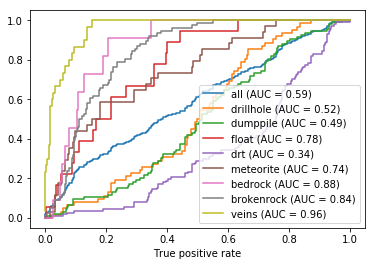

In [57]:
for cat in scores.keys():
    fpr, tpr, thresholds = roc_curve(y_true=scores[cat]['label'], y_score=scores[cat]['score'])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='%s (AUC = %0.2f)' % (cat, auc_score))
plt.legend()
plt.xlabel("False positive rate")
plt.xlabel("True positive rate")

### Compute Precision at N

Sort the combined test dataset (novel and typical images) by their novelty score

In [67]:
sorted_test = scores['all'].sort_values('score', ascending=False)

Compute Precision at N for the top-ranked images

In [77]:
# Choose the top N
N = 10
top_scores = np.array(sorted_test[:N]['score'])
top_labels = np.array(sorted_test[:N]['label'])
top_names = np.array(sorted_test[:N]['name'])

Precision at N=10: 0.900000


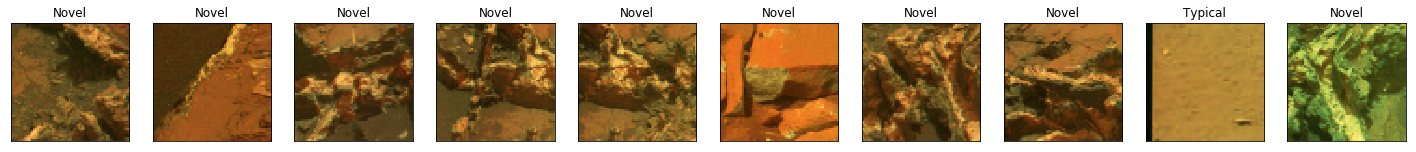

In [83]:
fig, axes = plt.subplots(ncols=N, figsize=(25, 15))
test_dir_typical = '/home/jovyan/data/test_typical'
test_dir_novel = '/home/jovyan/data/test_novel/all'
for i in range(N):
    axes[i].grid(False)
    axes[i].get_xaxis().set_ticks([])
    axes[i].get_yaxis().set_ticks([])
    if top_labels[i] == 0:
        img = np.load(os.path.join(test_dir_typical, '%s.npy' % top_names[i]))
        axes[i].set_title('Typical')
    elif top_labels[i] == 1:
        img = np.load(os.path.join(test_dir_novel, '%s.npy' % top_names[i]))
        axes[i].set_title('Novel')
    # Display the image
    img = np.take(img, [2,0,1], axis=2)
    axes[i].imshow(np.interp(img, (img.min(), img.max()), (0, 1)))
    
precision_at_N = len(np.where(np.array(top_labels) == 1)[0])
precision_at_N = precision_at_N / float(N)
print("Precision at N=%d: %f" % (N, precision_at_N))

### Compute False Negatives at N

False Negatives at N is the fraction of novel images that appear in the bottom N images when ranked by novelty score.

In [86]:
# Choose the bottom N
bottom_scores = np.array(sorted_test[-N:]['score'])
bottom_labels = np.array(sorted_test[-N:]['label'])
bottom_names = np.array(sorted_test[-N:]['name'])

Precision at N=10: 0.900000


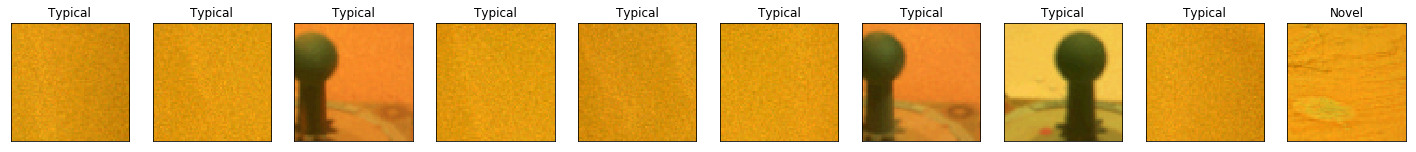

In [87]:
fig, axes = plt.subplots(ncols=N, figsize=(25, 15))
for i in range(N):
    axes[i].grid(False)
    axes[i].get_xaxis().set_ticks([])
    axes[i].get_yaxis().set_ticks([])
    if bottom_labels[i] == 0:
        img = np.load(os.path.join(test_dir_typical, '%s.npy' % bottom_names[i]))
        axes[i].set_title('Typical')
    elif bottom_labels[i] == 1:
        img = np.load(os.path.join(test_dir_novel, '%s.npy' % bottom_names[i]))
        axes[i].set_title('Novel')
    # Display the image
    img = np.take(img, [2,0,1], axis=2)
    axes[i].imshow(np.interp(img, (img.min(), img.max()), (0, 1)))
    
precision_at_N = len(np.where(np.array(bottom_labels) == 0)[0])
precision_at_N = precision_at_N / float(N)
print("Precision at N=%d: %f" % (N, precision_at_N))